In [1]:
!pip install nltk
!pip install contractions
!pip install contractions pyspellchecker
!pip install transformers
!pip install datasets
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 re

In [2]:
import re
import pandas as pd
from contractions import fix
import nltk
from contractions import fix
from spellchecker import SpellChecker
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset with unique column names
df = pd.read_csv('/content/drive/MyDrive/BERT/combined_output.csv', names=['sentence', 'label'], header=0)

# Check for duplicate column names
if df.columns.duplicated().any():
    df.columns = pd.Index([f"{col}_{i}" if i > 0 else col for i, col in enumerate(df.columns)])

# Initialize the spellchecker
spell = SpellChecker()

# Function for cleaning text
def preprocess_text(text):
    # 1. Transform to lowercase
    text = text.lower()

    # 2. Remove unimportant data: links, usernames, hashtags, digits, punctuation, emojis
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|\d+|[^\w\s]|[^\x00-\x7F]+', '', text)

    return text

# Apply preprocessing to the 'sentence' column
df['sentence'] = df['sentence'].apply(preprocess_text)

# Save the preprocessed dataset
df.to_csv('/content/drive/MyDrive/BERT/preprocessed_dataset.csv', index=False, encoding='utf-8')

print("Preprocessing complete. The dataset has been saved as 'preprocessed_dataset.csv'.")

Preprocessing complete. The dataset has been saved as 'preprocessed_dataset.csv'.


In [5]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
!pip install openpyxl

In [7]:
# Load dataset from a single CSV file
df = pd.read_csv('/content/drive/MyDrive/BERT/preprocessed_dataset.csv')  # Adjust this path as needed

# Load profanity list from Excel file
profane_words_df = pd.read_excel('/content/drive/MyDrive/BERT/ProfanityListBERT.xlsx', header=None)
profane_words_df.columns = ['profanity_list']
profane_words = set(profane_words_df['profanity_list'].tolist())

# Function to check if a sentence contains profane words
def contains_profane_words(sentence, profane_words):
    words = sentence.split()
    return any(word in profane_words for word in words)

# Add a feature to indicate whether a sentence contains profane words
df['contains_profane'] = df['sentence'].apply(lambda x: 1 if contains_profane_words(x, profane_words) else 0)

# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)  # 80% train
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)  # 10% val, 10% test

# Convert pandas DataFrames to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Load pre-trained BERT tokenizer and model for sequence classification (2 output classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization function for the dataset with the additional `contains_profane` feature
def tokenize_function(examples):
    tokenized = tokenizer(examples['sentence'], padding='max_length', max_length=128, truncation=True)
    tokenized['contains_profane'] = examples['contains_profane']  # Add the feature to the dataset
    return tokenized

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'contains_profane', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'contains_profane', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'contains_profane', 'label'])

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=0.00001,  # 1e-5 learning rate
    per_device_train_batch_size=64,  # batch size
    per_device_eval_batch_size=64,
    num_train_epochs=3,  # 3 epochs
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model('./trained_bert')

# Evaluate the model on the test dataset
results = trainer.evaluate(eval_dataset=test_dataset)
print("Evaluation Results:", results)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/65984 [00:00<?, ? examples/s]

Map:   0%|          | 0/8248 [00:00<?, ? examples/s]

Map:   0%|          | 0/8249 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.061900,0.050677
2,0.037000,0.030755
3,0.027500,0.030483


Evaluation Results: {'eval_loss': 0.03993121534585953, 'eval_runtime': 51.5784, 'eval_samples_per_second': 159.931, 'eval_steps_per_second': 2.501, 'epoch': 3.0}


Sentence: 'Ilarawan kung ano ang makikita mo kung pupunta ka sa Grand Canyon.' | Predicted: Not Profane | True Label: 0
Sentence: 'Saang bansa ipinanganak si Pangulong Roosevelt?' | Predicted: Not Profane | True Label: 0
Sentence: 'Dahil sa pangalan ng kanta, hulaan ang genre ng kanta.' | Predicted: Not Profane | True Label: 0
Sentence: 'Maghanap ng limang pang-uri na naglalarawan sa isang mahangin na araw' | Predicted: Not Profane | True Label: 0
Sentence: 'Ilarawan kung paano ang papel ng kasaysayan sa mundo ngayon.' | Predicted: Not Profane | True Label: 0
Sentence: 'Ilarawan ang kahalagahan ng data curation sa larangan ng data science.' | Predicted: Not Profane | True Label: 0
Sentence: 'Dahil sa sumusunod na pangungusap, i-edit ito para sa kalinawan at pagiging maikli.' | Predicted: Not Profane | True Label: 0
Sentence: 'Isulat muli ang pangungusap na ito upang magdagdag ng iba't ibang uri sa mga pandiwang ginamit.' | Predicted: Not Profane | True Label: 0
Sentence: 'Ipaliwanag ku

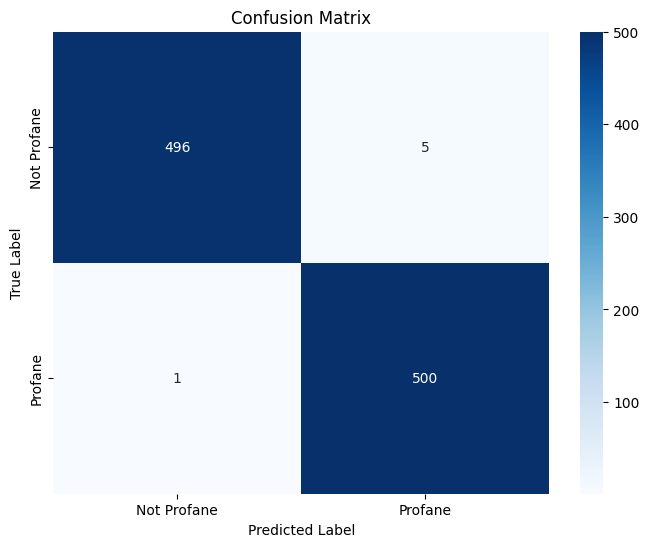

In [20]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Tagalog.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'sa komun na arapodan orog na sa mga eskwelahan natotomoyan ining bayan magiliw' | Predicted: Not Profane | True Label: 0
Sentence: 'siya nagin aktibong kaapil kan partido liberal asin ngane nagin tesorero asin adviser kan partidong ini' | Predicted: Not Profane | True Label: 0
Sentence: 'pigkaag man sa posisyon sa department of earth and planetary science asin sa department of environmental science policy and management' | Predicted: Not Profane | True Label: 0
Sentence: 'an saiyang pamomoon sa kambodya bantog sa maringis na pagtrato sa sadiri niyang kahimanwa mala ta sinasabing napagadan niya an haros kan populasyon sa kun anoanong rason' | Predicted: Not Profane | True Label: 0
Sentence: 'an amerikanang parakanta na si lady gaga nagpaluwas nin tolong video albums asin nakaluwas sa trentang mga music video' | Predicted: Not Profane | True Label: 0
Sentence: 'pero bilang tropikal na depresyon sa katapustapusi kan hulyo nagkaigwa nin tropikal na depresyon sa solnopan na pasip

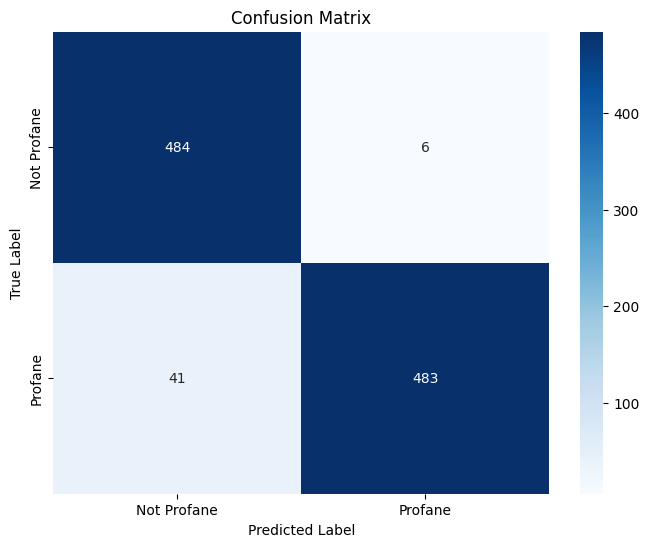

In [21]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Bikol.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'kung di ka mokaon' | Predicted: Not Profane | True Label: 0
Sentence: 'kinahanglan og pintal sa panimalay nimo' | Predicted: Not Profane | True Label: 0
Sentence: 'tinuod diay tong hungihong' | Predicted: Not Profane | True Label: 0
Sentence: 'dili na siya na siya mungisi nako' | Predicted: Not Profane | True Label: 0
Sentence: 'nagatuo sila sa kinabuhi human sa kamatayon' | Predicted: Not Profane | True Label: 0
Sentence: 'kanusa nimo siya nakitan nga gisayawan niya siya' | Predicted: Not Profane | True Label: 0
Sentence: 'wala ko naghunahuna kadiyot nga sayop ka' | Predicted: Not Profane | True Label: 0
Sentence: 'namatay ang akong lolo sa ikaduhang digmaang kalibutanon' | Predicted: Not Profane | True Label: 0
Sentence: 'magpakamatay siya inig dili niya makita iyahang anak' | Predicted: Not Profane | True Label: 0
Sentence: 'gusto ni tatay nga magskwela ko sa laing nasud samtang bata pa ko' | Predicted: Not Profane | True Label: 0
Sentence: 'nakawala na ko sa akoang tatay

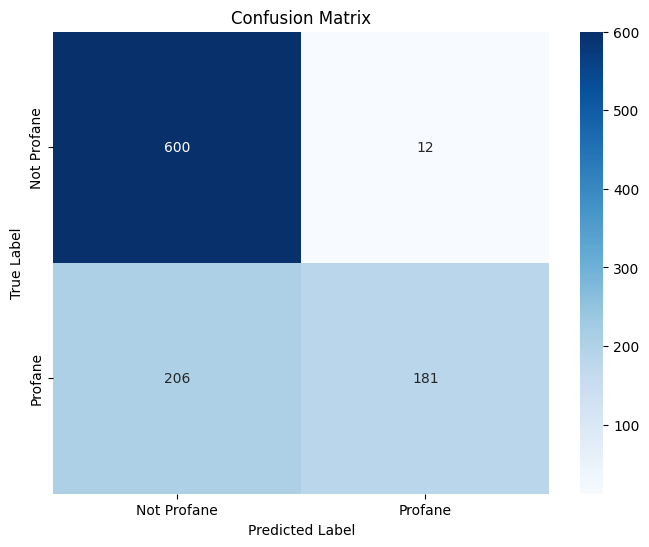

In [22]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/Testing_Data - Cebuano.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'bwiset talaga mga tawo digdi' | Predicted: Profane | True Label: 1
Sentence: 'Pagsusuri ng damdamin ng teksto sa ibaba.' | Predicted: Not Profane | True Label: 0
Sentence: 'puta gayunon gabos dipisilon magpili kaya ilikom na sana gabos' | Predicted: Profane | True Label: 1
Sentence: 'asa ang hunungan sa hakata' | Predicted: Not Profane | True Label: 0
Sentence: 'haha ganiyan na ang life cycle mo bro kahit siguro si lord hindi masisikmura katarantaduhan mong gago ka' | Predicted: Profane | True Label: 1
Sentence: 'pucha yung boses parang naipit' | Predicted: Profane | True Label: 1
Sentence: 'chariz puta pinatay agad tv' | Predicted: Profane | True Label: 1
Sentence: 'an bantog na prinsipyo na magbigay ng ayon sa kakayahan' | Predicted: Not Profane | True Label: 0
Sentence: 'Ang bogo kuno nga bata maoy una nga nakab-ot sa taas nga ranggo.' | Predicted: Not Profane | True Label: 1
Sentence: 'ang ubang mga ihalas nga hayop nga nailhan nga nagpuyo sa lugar naglakip sa monitor sa

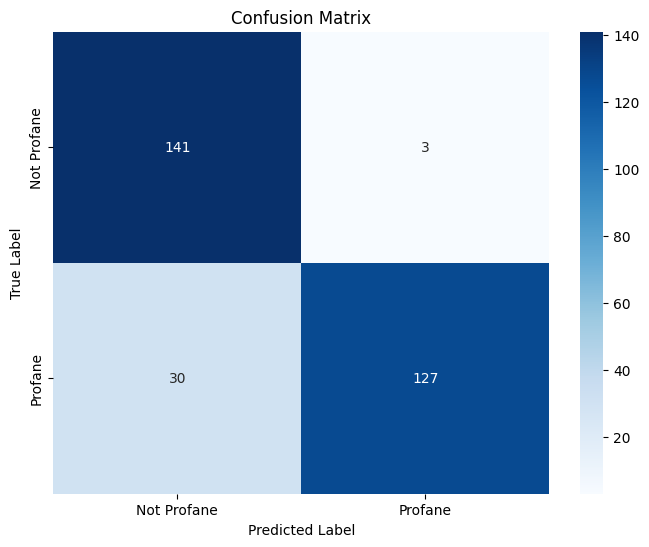

In [9]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_1.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'habo ko na pakshet' | Predicted: Profane | True Label: 1
Sentence: 'dangag mag aki ka' | Predicted: Profane | True Label: 1
Sentence: 'ug sa pultahan sa balongbalong nga pagatiguman magpuyo kamo sa adlaw ug sa gabii sulod sa pito ka adlaw' | Predicted: Not Profane | True Label: 0
Sentence: 'ang kolor sa kini nga koral mao ang kolor de letse o luspad nga brown ug ang mga tumoy sa sanga usahay nagapula' | Predicted: Profane | True Label: 1
Sentence: 'nagluwas naman an saiyang tula sa liwayway magazinekalatasliteraryzine httpskalatasliteraryezine' | Predicted: Not Profane | True Label: 0
Sentence: 'haha tangina umaga nanaman' | Predicted: Profane | True Label: 1
Sentence: 'ug siya nga wala magtagad sa pulong ni jehova' | Predicted: Not Profane | True Label: 0
Sentence: 'ug kong ang mga tawo sa yuta magatago gayud sa ilang mga mata gikan niadtong tawohana' | Predicted: Not Profane | True Label: 0
Sentence: 'unya ang tagiya sa balay' | Predicted: Not Profane | True Label: 0
Sente

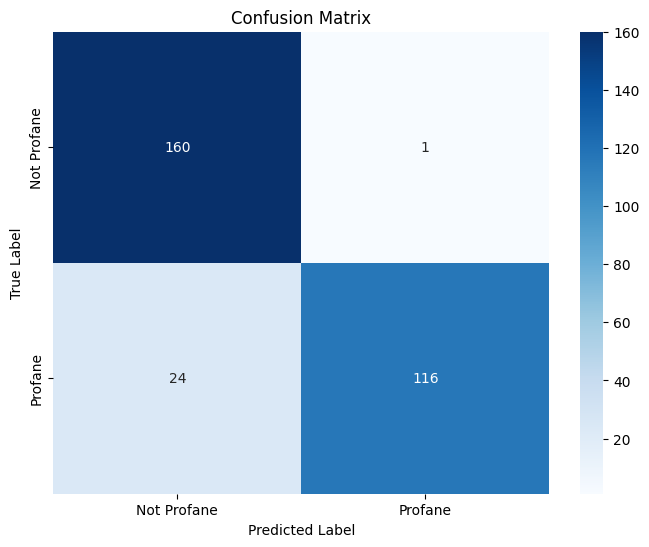

In [10]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_2.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'garo ka patal ade nata kaipuhan mo pa itong ipost papansin kang kupal ka' | Predicted: Profane | True Label: 1
Sentence: 'istresson na naman akong bulininaniya' | Predicted: Not Profane | True Label: 1
Sentence: 'Dapat nato piniste ang mga kahuyang sa atong balay.' | Predicted: Not Profane | True Label: 1
Sentence: 'arug kaan magpaugma bako itong nagkaon kana kaonon taka' | Predicted: Not Profane | True Label: 0
Sentence: 'tarantado may speech kapa sako' | Predicted: Profane | True Label: 1
Sentence: 'an nasyunal na akademya kan siyensya asin teknolohiya' | Predicted: Not Profane | True Label: 0
Sentence: 'Pangalanan ang tatlong panganib na nauugnay sa online banking.' | Predicted: Not Profane | True Label: 0
Sentence: 'Tukuyin ang tatlong katangian ng ibinigay na species.' | Predicted: Not Profane | True Label: 0
Sentence: 'ug kadtong mga nangamatay pinaagi sa hampak may kaluhaan ug upat ka libo' | Predicted: Not Profane | True Label: 0
Sentence: 'ug ang tanan nga mga adlaw

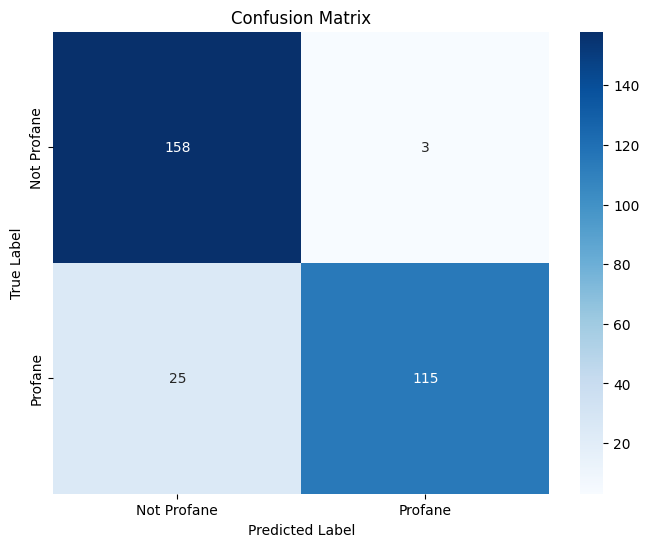

In [11]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_3.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'Ibahin ang anyo ng mga sumusunod na pangungusap mula sa ika-3 tao hanggang sa ika-2 tao.' | Predicted: Not Profane | True Label: 0
Sentence: 'muya ko man matapos na gabos pero putangina dae man pwedeng ako sana matapos gabos' | Predicted: Profane | True Label: 1
Sentence: 'Ibuod ang mga pangunahing punto ng ibinigay na talata.' | Predicted: Not Profane | True Label: 0
Sentence: 'also available as and nagsurat sia nin artikulo para sa mtv news para sa ika anibersaryo kan aldaw nin daga na tinabangan niang makoordinar' | Predicted: Not Profane | True Label: 0
Sentence: 'unya si jose mitungas sa paglubong sa iyang amahan ug mitungas uban kaniya ang tanang mga ulipon ni faraon' | Predicted: Not Profane | True Label: 0
Sentence: 'apan mahitungod kanako sa paggikan ko sa padanaram' | Predicted: Not Profane | True Label: 0
Sentence: 'bwiset nagka parasa su mga ginibo ni may' | Predicted: Profane | True Label: 1
Sentence: 'Hanapin ang nakatagong mensahe sa string ng mga salita' | Pr

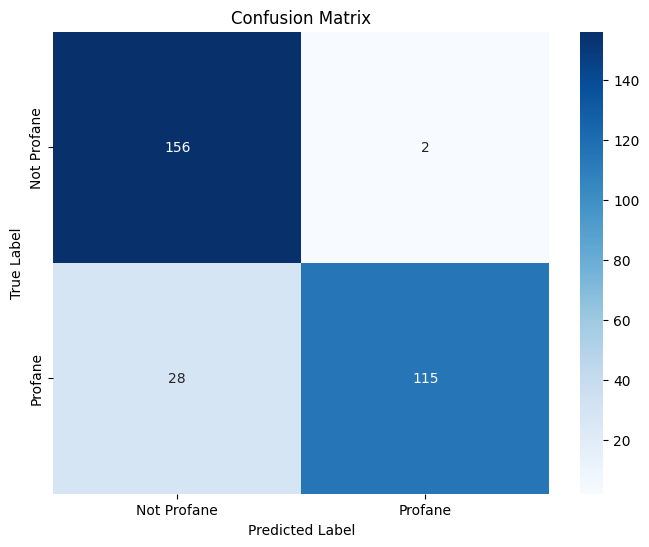

In [12]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_4.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'sisay na patal ang naiinlove sa pinsan' | Predicted: Profane | True Label: 1
Sentence: 'Tukuyin ang 3 pagkakaiba sa pagitan ng data science at artificial intelligence.' | Predicted: Not Profane | True Label: 0
Sentence: 'bisan kadtong mga naisip pinaagi sa ilang mga panimalay' | Predicted: Not Profane | True Label: 0
Sentence: 'patranslate daw patal ako' | Predicted: Profane | True Label: 1
Sentence: 'dili ko naga sulob ug sapatos sa sulud sa akoang panimalay' | Predicted: Not Profane | True Label: 0
Sentence: 'gago hindi ko na kaya' | Predicted: Profane | True Label: 1
Sentence: 'unsa ang tawag sa hayop niini sa hapon' | Predicted: Profane | True Label: 1
Sentence: 'Sumulat ng isang 500-salitang kuwento tungkol sa isang batang ulila na nakatuklas ng isang nakatagong mahiwagang kapangyarihan.' | Predicted: Not Profane | True Label: 0
Sentence: 'umari ka kanako ayaw pagdugay' | Predicted: Not Profane | True Label: 0
Sentence: 'joke lang pala yung lamang nanaman si marsie haha

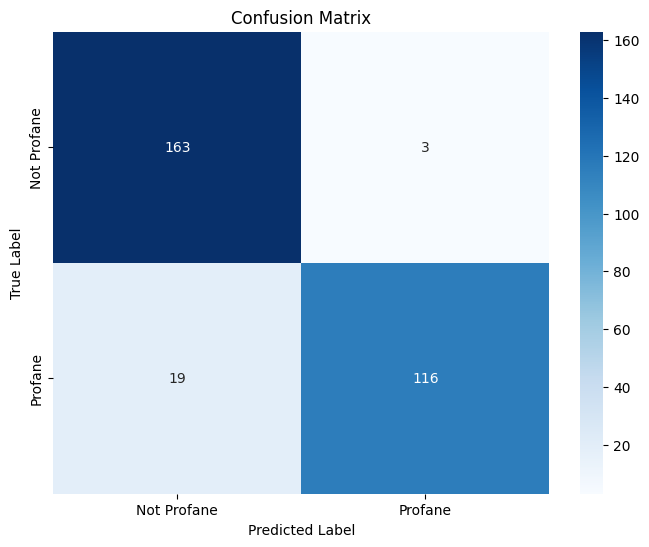

In [13]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_5.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'haha gago kala ko' | Predicted: Profane | True Label: 1
Sentence: 'asarin ko din kaya sila pag nag break sila hindi ba magagalit din siya tarantado ka' | Predicted: Profane | True Label: 1
Sentence: 'Di ka angay magtan-aw sa uban, mura kag animal!' | Predicted: Not Profane | True Label: 1
Sentence: 'ug dadon mo kini sa imong amahan' | Predicted: Not Profane | True Label: 0
Sentence: 'ang soolohiya bahin sa pagtuon sa kinabuhi sa hayop' | Predicted: Profane | True Label: 1
Sentence: 'aktibong myembro man sya kan african unions network of african women in conflict prevention and mediation' | Predicted: Not Profane | True Label: 0
Sentence: 'sorry talaga cy kung tarantado ako' | Predicted: Profane | True Label: 1
Sentence: 'nakaka ulol beh diko na kinakaya' | Predicted: Profane | True Label: 1
Sentence: 'Gumawa ng orihinal na kwento tungkol sa isang elepante' | Predicted: Not Profane | True Label: 0
Sentence: 'ug mitubag si abram o' | Predicted: Not Profane | True Label: 0
Sent

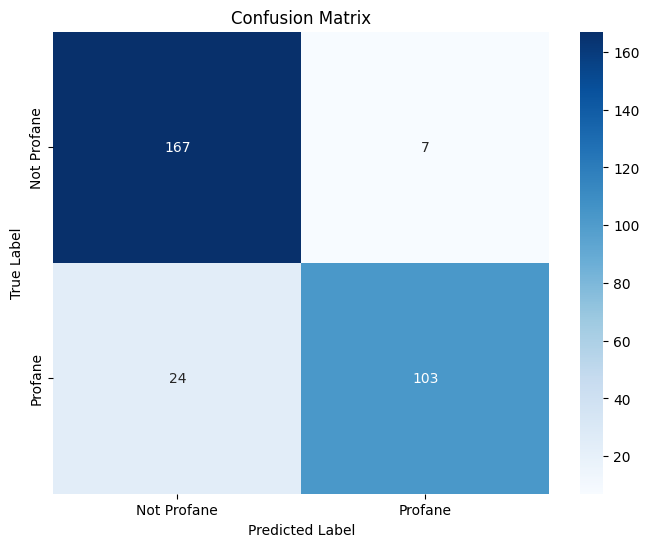

In [14]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_6.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'dagko ang ilang mga oten' | Predicted: Not Profane | True Label: 1
Sentence: 'ug ang mga anak nga lalake ni cora si aser ug si elcana' | Predicted: Not Profane | True Label: 0
Sentence: 'Para sa isang website, ano ang ibig sabihin ng SEO?' | Predicted: Not Profane | True Label: 0
Sentence: 'Ang akong mama miingon nga kinahanglan piniste nato ang tanang hugaw.' | Predicted: Not Profane | True Label: 1
Sentence: 'porket ours in love agad tangina niyo pala eh' | Predicted: Profane | True Label: 1
Sentence: 'sweet sweetan kami dito ni kupal haha' | Predicted: Profane | True Label: 1
Sentence: 'ang purongpurong sa mga manggialamon mao ang ilang mga bahandi apan ang binuang sa mga buang mao lamang ang kabuangan' | Predicted: Profane | True Label: 1
Sentence: 'Animal imong pagkatawo, walay laing kahulugan!' | Predicted: Not Profane | True Label: 1
Sentence: 'nikaon kuno ang tagiya sa sakyanan sa restawran apan pagbalik niya nakuyawan na lang siya sa dihang makitan nga nabuak ang sa

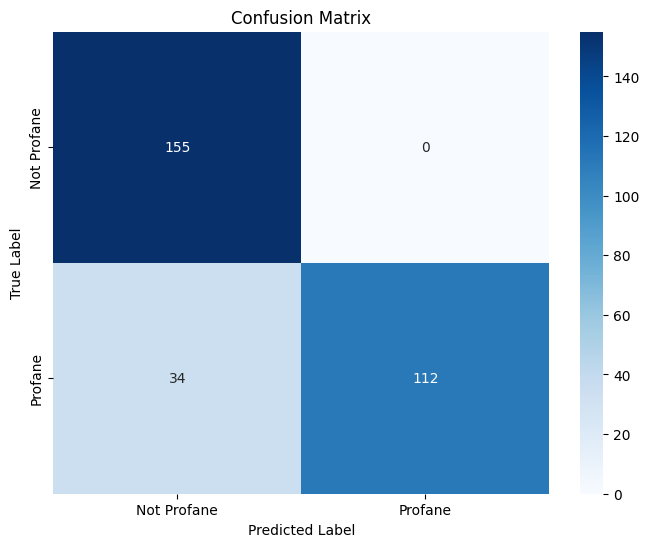

In [15]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_7.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'putangina nindo ako na sana kaya masapak saindo mga puta' | Predicted: Profane | True Label: 1
Sentence: 'Ang among barangay kapitan piniste sa tanang reklamo sa komunidad.' | Predicted: Not Profane | True Label: 1
Sentence: 'diha ako magpuyo sa imong balay sulod sa kaluhaan ka tuig napulo ug upat ka tuig ako nagalagad kanimo tungod sa imong duruha ka mga anak nga babaye' | Predicted: Not Profane | True Label: 0
Sentence: 'natural born tarantado po ako pasensya na' | Predicted: Profane | True Label: 1
Sentence: 'kabado bente ako tangina saglit' | Predicted: Profane | True Label: 1
Sentence: 'nagpundo an siring na gawi hasta sa maaraman na kan parabasa na pigkua palan ni keiko an saiyang sadiring buhay' | Predicted: Not Profane | True Label: 0
Sentence: 'tungod niini kanila gibahinbahin ang kapupudan sa mga nasud sa ilang mga yuta' | Predicted: Not Profane | True Label: 0
Sentence: 'enot na nagkahilingan sinda vallejo asin bachelet sa sarong campaign event kadtong ika nin hun

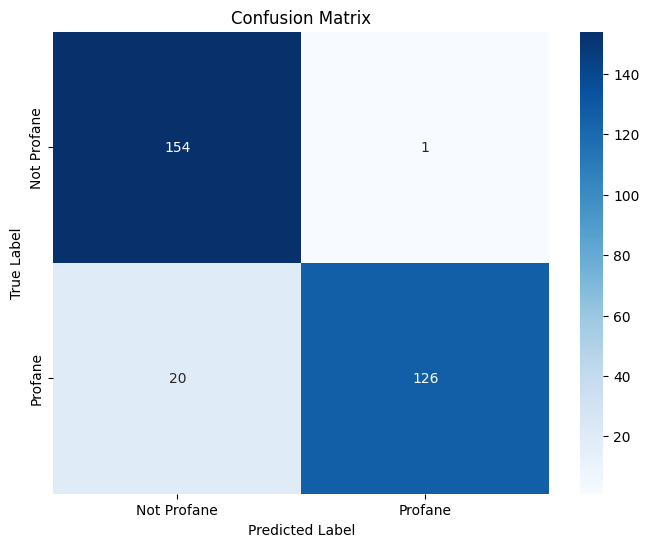

In [16]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_8.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'Magbigay ng halimbawa ng isang sitwasyon kung kailan dapat kong gamitin ang pagpapasya.' | Predicted: Not Profane | True Label: 0
Sentence: 'dakol na pinagkapararehas sa lado nin balanghayan an diyalektong shikoku sa diyalektong chgoku' | Predicted: Not Profane | True Label: 0
Sentence: 'anopang masabi si marcos an guminanang labilabi sa eleksyon na idto asin sinawsawan si macapagal' | Predicted: Not Profane | True Label: 0
Sentence: 'sa tanan nga mga adlaw nga mibulag siya sa iyang kaugalingon alang kang jehova' | Predicted: Not Profane | True Label: 0
Sentence: 'pikaudo na ako sa kurab tangina' | Predicted: Profane | True Label: 1
Sentence: 'tangina nindo pldt ano na nanggad' | Predicted: Profane | True Label: 1
Sentence: 'hindi ka pwede sa pa give away ko mi mga bobo lang pwede dito haha' | Predicted: Profane | True Label: 1
Sentence: 'Loslos nimo inday' | Predicted: Not Profane | True Label: 1
Sentence: 'huni pa saro ulol ka man ngane' | Predicted: Profane | True Label: 

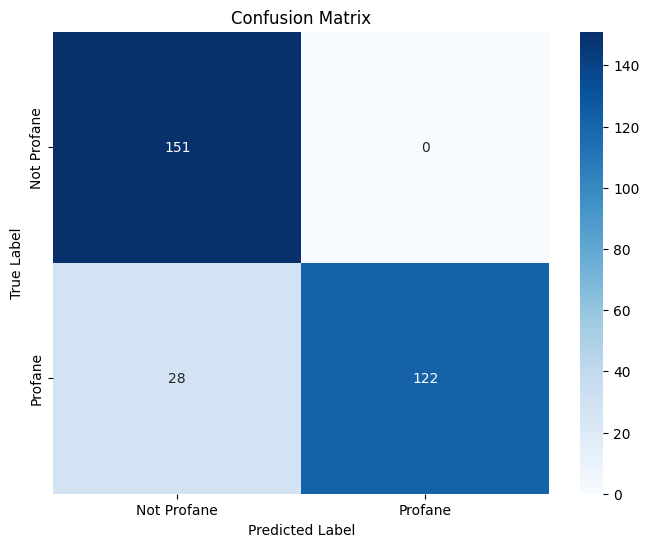

In [17]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_9.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'Animal man sad ka, walay respeto sa uban!' | Predicted: Not Profane | True Label: 1
Sentence: 'igwa ining sukol nin kilometro kwadradong kadagaan asin namumugtak sa solong distrito' | Predicted: Not Profane | True Label: 0
Sentence: 'gare kupal su waiter kay kenya sa rhoa makulugon sa mata hilingon' | Predicted: Profane | True Label: 1
Sentence: 'Bumuo ng isang piraso ng dialog sa pagitan ng dalawang karakter na tumatalakay sa kasalukuyang panahon.' | Predicted: Not Profane | True Label: 0
Sentence: 'pc pala ang wala ako pakshet' | Predicted: Profane | True Label: 1
Sentence: 'kahit sa airport na malayuan ko lang makita okay na sana tangina naman' | Predicted: Profane | True Label: 1
Sentence: 'an tunong ka ini ay magiging katinig na l pag pigdagdagan nin virama an irarom' | Predicted: Not Profane | True Label: 0
Sentence: 'Baguhin ang sumusunod na parirala upang makagawa ng isang retorika na tanong' | Predicted: Not Profane | True Label: 0
Sentence: 'ug si jehova miingon ka

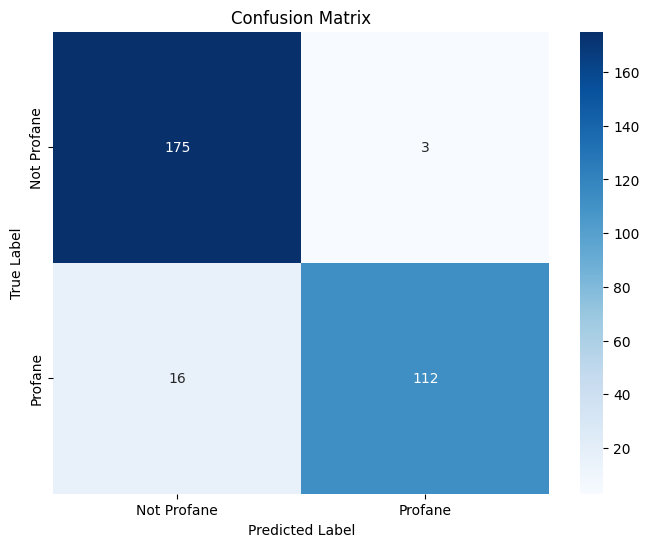

In [18]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/instance_10.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Sentence: 'sa komun na arapodan orog na sa mga eskwelahan natotomoyan ining bayan magiliw' | Predicted: Not Profane | True Label: 0
Sentence: 'siya nagin aktibong kaapil kan partido liberal asin ngane nagin tesorero asin adviser kan partidong ini' | Predicted: Not Profane | True Label: 0
Sentence: 'pigkaag man sa posisyon sa department of earth and planetary science asin sa department of environmental science policy and management' | Predicted: Not Profane | True Label: 0
Sentence: 'an saiyang pamomoon sa kambodya bantog sa maringis na pagtrato sa sadiri niyang kahimanwa mala ta sinasabing napagadan niya an haros kan populasyon sa kun anoanong rason' | Predicted: Not Profane | True Label: 0
Sentence: 'an amerikanang parakanta na si lady gaga nagpaluwas nin tolong video albums asin nakaluwas sa trentang mga music video' | Predicted: Not Profane | True Label: 0
Sentence: 'pero bilang tropikal na depresyon sa katapustapusi kan hulyo nagkaigwa nin tropikal na depresyon sa solnopan na pasip

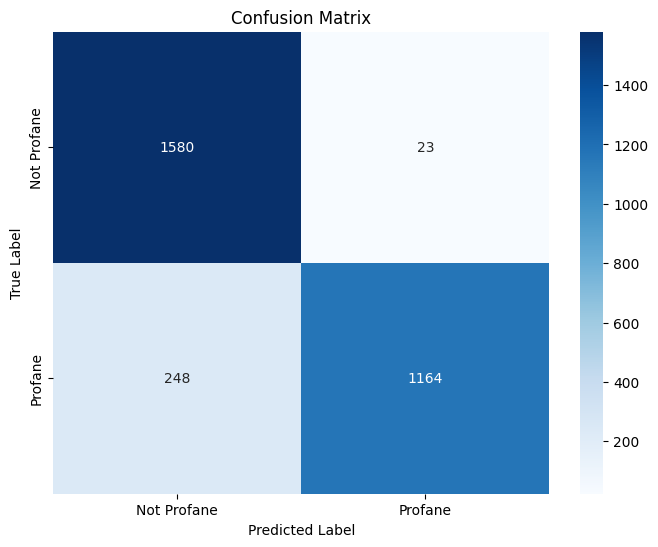

In [23]:
# Initialize counters for metrics calculation
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Determine the device for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load CSV file
file_path = '/content/drive/MyDrive/BERT/combined.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Loop through the rows of the DataFrame
for index, row in data.iterrows():
    sentence = row['sentence']
    true_label = row['profane']

    # Tokenize the input sentence and move to the appropriate device
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device as the model

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted class (0: Not Profane, 1: Profane)
    predicted_class = torch.argmax(logits, dim=-1).item()

    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_class)

    # Update counters
    if predicted_class == 1 and true_label == 1:
        tp += 1  # True Positive
    elif predicted_class == 0 and true_label == 0:
        tn += 1  # True Negative
    elif predicted_class == 1 and true_label == 0:
        fp += 1  # False Positive
    elif predicted_class == 0 and true_label == 1:
        fn += 1  # False Negative

    # Print the result
    if predicted_class == 1:
        print(f"Sentence: '{sentence}' | Predicted: Profane | True Label: {true_label}")
    else:
        print(f"Sentence: '{sentence}' | Predicted: Not Profane | True Label: {true_label}")

# Calculate Precision, Recall, F1-Score, and Accuracy
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Create Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Profane", "Profane"], yticklabels=["Not Profane", "Profane"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()